# Chapter 7: Image Segmentation

***

# Threshold based Segmentation techniques

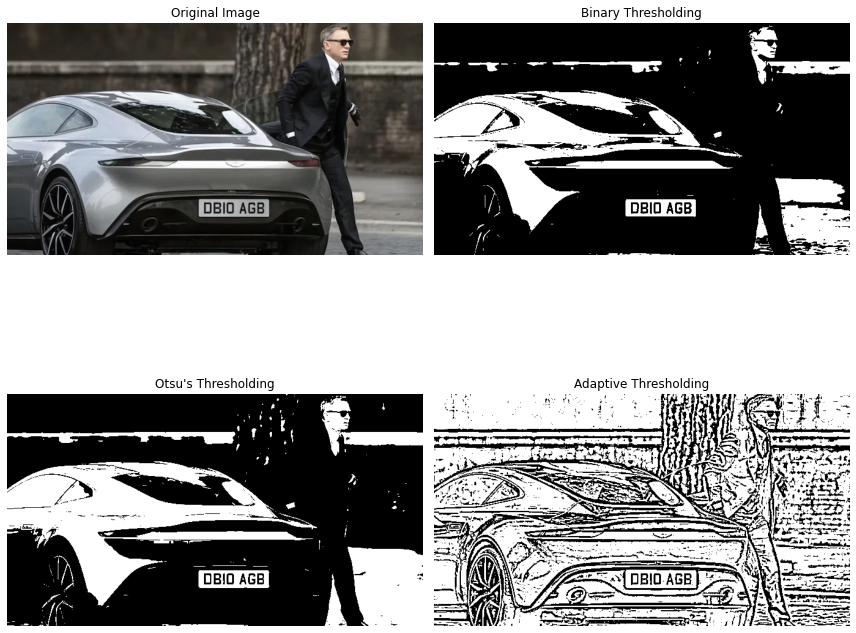

In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./images/db10.webp')  # Make sure to replace with the correct path to your image
if img is None:
    raise ValueError("Image not found. Please check the file path.")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Apply a simple global threshold
threshold_value = 128
_, binary_thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

# Step 2: Apply Otsu's thresholding (automatic thresholding)
otsu_thresh, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 3: Apply Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, 
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)

# Step 4: Plotting the results
plt.figure(figsize=(12, 12))  # Optional: Adjust size for better visibility

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Binary Threshold Image
plt.subplot(2, 2, 2)
plt.imshow(binary_thresh, cmap='gray')
plt.title('Binary Thresholding')
plt.axis('off')

# Otsu's Threshold Image
plt.subplot(2, 2, 3)
plt.imshow(binary_otsu, cmap='gray')
plt.title("Otsu's Thresholding")
plt.axis('off')

# Adaptive Threshold Image
plt.subplot(2, 2, 4)
plt.imshow(adaptive_thresh, cmap='gray')
plt.title('Adaptive Thresholding')
plt.axis('off')

plt.tight_layout()
plt.show()

# Region Based Segmentation techniques

Region-based segmentation techniques are a class of image segmentation methods that divide an image into regions based on the similarity of pixels. The idea is to group neighboring pixels that have similar properties, such as intensity, color, or texture, into meaningful regions. These methods rely on analyzing the homogeneity within a region, unlike edge-based techniques that focus on the boundaries between regions.

Types of Region-Based Segmentation:
    
- Region Growing: Starts with a seed point and grows a region by adding neighboring pixels that are similar to the seed point.

- Watershed Segmentation: Treats the image as a topographic surface where high-intensity pixels represent peaks and low-intensity pixels represent valleys, helping to segment different regions.

## Region Growing (single seed-point)

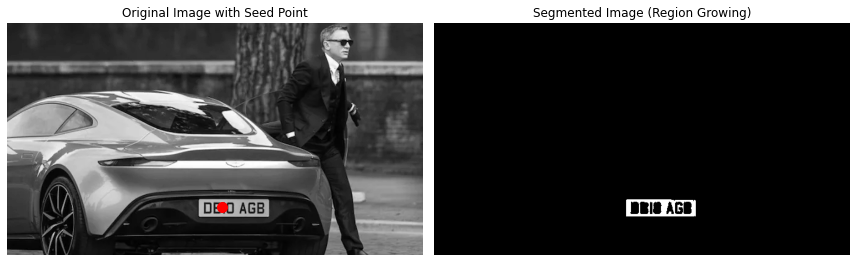

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed_point, threshold):
    """
    Implements region growing segmentation.
    """
    height, width = image.shape
    segmented_image = np.zeros((height, width), dtype=np.uint8)
    region_size = 0
    region_mean = image[seed_point[1], seed_point[0]]  # Initial mean (access with y, x)
    pixels_to_check = [seed_point]
    segmented_image[seed_point[1], seed_point[0]] = 255  # Mark seed point in segmented image

    while len(pixels_to_check) > 0:
        x, y = pixels_to_check.pop(0)
        region_size += 1
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height:
                    if segmented_image[ny, nx] == 0 and abs(int(image[ny, nx]) - int(region_mean)) < threshold:
                        segmented_image[ny, nx] = 255
                        pixels_to_check.append((nx, ny))
                        region_mean = (region_mean * region_size + image[ny, nx]) / (region_size + 1)

    return segmented_image

# Load the image
img = cv2.imread('./images/db10.webp', cv2.IMREAD_GRAYSCALE)  # Query image

# Set seed point and threshold
seed_point = (350, 300)  # Example: Change as needed (x, y)
threshold = 20  # Example: Change as needed

# Perform region growing
segmented = region_growing(img, seed_point, threshold)

# Plotting the images
plt.figure(figsize=(12, 6))

# Plot 1: Original image with the seed point in red
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.scatter(seed_point[0], seed_point[1], color='red', s=100)  # Seed point plotted in red
plt.title('Original Image with Seed Point')
plt.axis('off')

# Plot 2: Segmented image
plt.subplot(1, 2, 2)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented Image (Region Growing)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Region Growing (multiple seed-point)

Image dimensions: (379, 680)


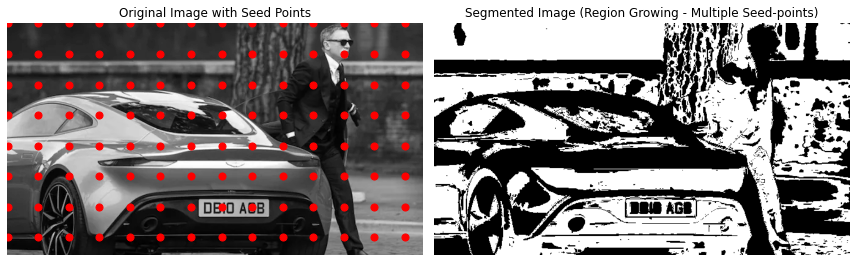

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed_points, threshold):
    """
    Implements region growing segmentation for multiple seed points.
    """
    height, width = image.shape
    segmented_image = np.zeros((height, width), dtype=np.uint8)
    region_mean = np.zeros(len(seed_points))  # Store mean for each region separately
    region_size = np.zeros(len(seed_points))  # Track size for each region
    pixels_to_check = seed_points[:]  # Initialize with all seed points

    # Initialize region mean and segmented image
    for i, seed_point in enumerate(seed_points):
        region_mean[i] = image[seed_point[1], seed_point[0]]  # (y, x)
        segmented_image[seed_point[1], seed_point[0]] = 255  # Mark initial seeds

    # Process pixels to check
    while len(pixels_to_check) > 0:
        (x, y, region_index) = pixels_to_check.pop(0)
        region_size[region_index] += 1
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height:
                    if segmented_image[ny, nx] == 0 and abs(int(image[ny, nx]) - int(region_mean[region_index])) < threshold:
                        segmented_image[ny, nx] = 255
                        pixels_to_check.append((nx, ny, region_index))
                        region_mean[region_index] = (region_mean[region_index] * region_size[region_index] + image[ny, nx]) / (region_size[region_index] + 1)

    return segmented_image

# Load the image (adjust to the correct path for a 680x399 image)
img = cv2.imread('./images/db10.webp', cv2.IMREAD_GRAYSCALE)  # Query image

# Check image size for confirmation
print(f"Image dimensions: {img.shape}")

# Automatically generate seed points every 50 pixels (including borders)
seed_points = []
for x in range(0, img.shape[1], 50):  # Loop through x-axis with a step of 50
    for y in range(0, img.shape[0], 50):  # Loop through y-axis with a step of 50
        seed_points.append((x, y))  # Append each (x, y) as a seed point

# Prepare seed points for region growing (x, y, region_index)
seed_points_with_index = [(x, y, i) for i, (x, y) in enumerate(seed_points)]

# Set threshold for region growing
threshold = 10  # Example: Change as needed

# Perform region growing with seed points every 50 pixels
segmented = region_growing(img, seed_points_with_index, threshold)

# Plotting the images
plt.figure(figsize=(12, 6))

# Plot 1: Original image with seed points in red
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
for seed in seed_points:
    plt.scatter(seed[0], seed[1], color='red', s=50)  # Seed points in red
plt.title('Original Image with Seed Points')
plt.axis('off')

# Plot 2: Segmented image
plt.subplot(1, 2, 2)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented Image (Region Growing - Multiple Seed-points)')
plt.axis('off')

plt.tight_layout()
plt.show()

**Thresholding** is fast and effective for simple segmentation tasks where the object stands out in terms of intensity.

**Region Growing** offers more sophisticated segmentation, especially for complex, noisy images where connectivity and gradual changes in intensity are important.

## Watershed Segmentation

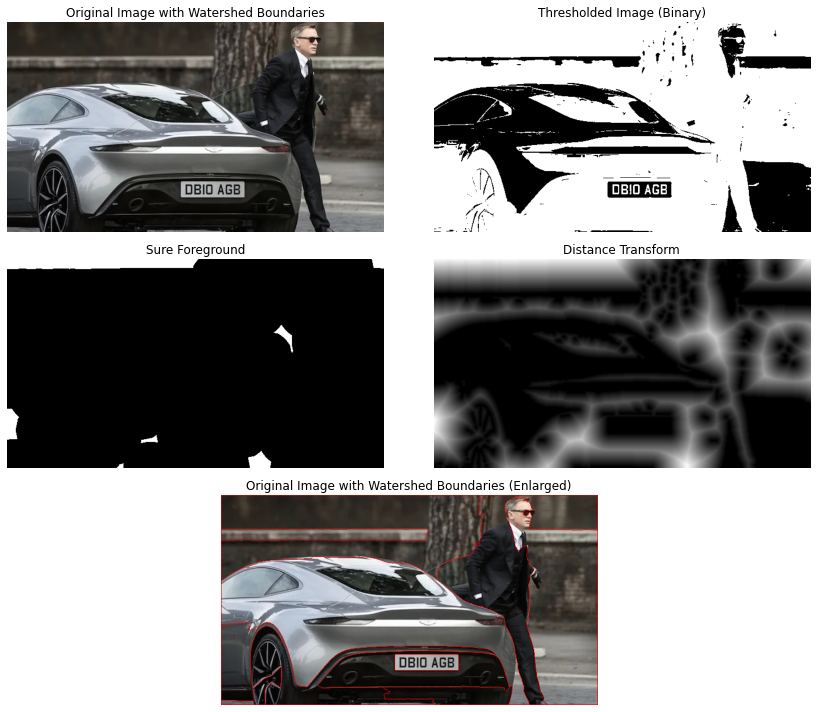

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./images/db10.webp')  # Query image
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Apply a threshold to the image to segment the foreground from the background
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 2: Remove small noise using morphological operations (opening)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 3: Sure background (dilate the opening)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Step 4: Sure foreground (distance transform and thresholding)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Step 5: Find unknown region (subtract sure foreground from sure background)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Step 6: Marker labeling
_, markers = cv2.connectedComponents(sure_fg)

# Step 7: Add 1 to all labels so that the background is not labeled as 0
markers = markers + 1

# Step 8: Mark the unknown regions as 0
markers[unknown == 255] = 0

# Step 9: Apply the watershed algorithm
markers = cv2.watershed(img, markers)

# The boundary of objects is marked with -1, color these boundaries
watershed_img = img.copy()
watershed_img[markers == -1] = [0, 0, 255]  # Mark boundaries in red

# Plotting the results
plt.figure(figsize=(12, 10))

# Original Image
plt.subplot2grid((3, 2), (0, 0))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Watershed Boundaries')
plt.axis('off')

# Thresholded Image
plt.subplot2grid((3, 2), (0, 1))
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image (Binary)')
plt.axis('off')

# Sure Foreground
plt.subplot2grid((3, 2), (1, 0))
plt.imshow(sure_fg, cmap='gray')
plt.title('Sure Foreground')
plt.axis('off')

# Distance Transform
plt.subplot2grid((3, 2), (1, 1))
plt.imshow(dist_transform, cmap='gray')
plt.title('Distance Transform')
plt.axis('off')

# Enlarged plot for Original Image with Watershed Boundaries
plt.subplot2grid((3, 2), (2, 0), colspan=2)
plt.imshow(cv2.cvtColor(watershed_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Watershed Boundaries (Enlarged)')
plt.axis('off')

plt.tight_layout()
plt.show()

**Why Watershed?**

Watershed segmentation is useful when you have overlapping or touching objects that are difficult to separate using simple methods like thresholding. It works well in applications like:

- Object segmentation in industrial inspection.

- Medical imaging, to segment regions of interest (e.g., tumors).

- Shape analysis, where the precise boundaries of objects need to be detected.

# k-clustering based Image segmentation

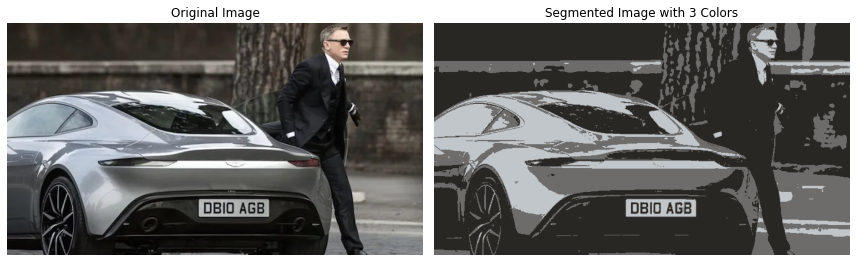

In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./images/db10.webp')  # Make sure to replace with the correct path to your image
if img is None:
    raise ValueError("Image not found. Please check the file path.")

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixel_values = img_rgb.reshape((-1, 3))  # Reshape to (num_pixels, 3)

# Convert to float type
pixel_values = np.float32(pixel_values)

# Define criteria and apply K-Means
k = 3  # Number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert the centers to uint8
centers = np.uint8(centers)

# Map the labels to the center colors
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img_rgb.shape)

# Ensure color values are between 0 and 255
segmented_image = np.clip(segmented_image, 0, 255).astype(np.uint8)

# Plotting the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title(f'Segmented Image with {k} Colors')
plt.axis('off')

plt.tight_layout()
plt.show()

## Edge Based Image Segmentation

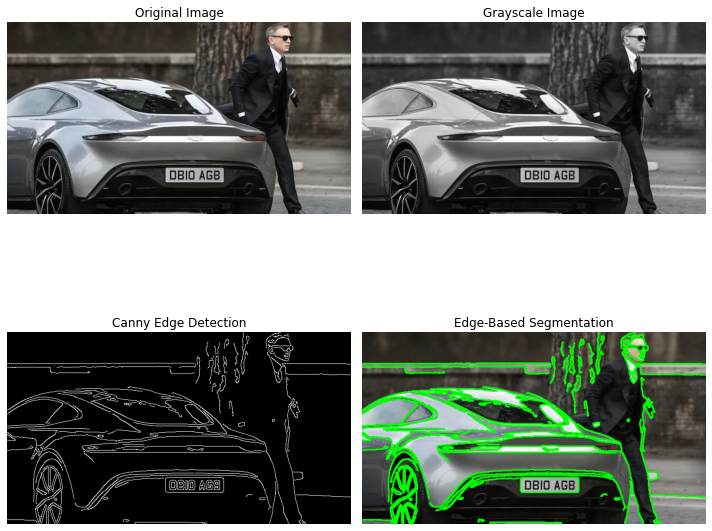

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./images/db10.webp')  # Make sure to replace with the correct path to your image
if img is None:
    raise ValueError("Image not found. Please check the file path.")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Apply Gaussian Blur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)

# Step 2: Perform Canny edge detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Step 3: Find contours from the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Draw contours on the original image
segmented_image = img.copy()
cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)  # Draw contours in green

# Plotting the results
plt.figure(figsize=(10, 10))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Grayscale Image
plt.subplot(2, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Canny Edge Detection
plt.subplot(2, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

# Segmented Image with Contours
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Edge-Based Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()

# Application : find Licence Plate

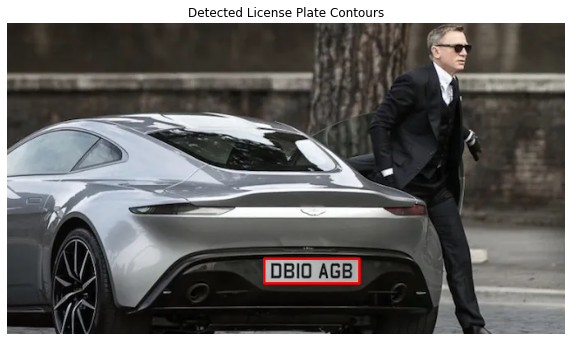

Number of valid contours found: 1
Contour 1: Area = 3323.0, Bounding Box = (313, 287, 116, 30)


In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./images/db10.webp')  # Make sure to replace with the correct path to your image
if img is None:
    raise ValueError("Image not found. Please check the file path.")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Apply Gaussian Blur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)

# Step 2: Perform Canny edge detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Step 3: Find contours from the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Initialize a list to store valid contours
valid_contours = []

# Define criteria for a license plate (aspect ratio and area)
min_area = 500  # Minimum area threshold
aspect_ratio_range = (2.0, 6.0)  # Typical aspect ratio range for license plates

# Loop through contours to find those that look like a license plate
for contour in contours:
    # Get the bounding rectangle for each contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate aspect ratio and area
    current_area = cv2.contourArea(contour)
    current_aspect_ratio = w / float(h)
    
    # Check if the contour meets the criteria
    if current_area > min_area and aspect_ratio_range[0] < current_aspect_ratio < aspect_ratio_range[1]:
        valid_contours.append(contour)

# Step 5: Draw all valid contours on the original image
detected_image = img.copy()
for contour in valid_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(detected_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Draw in red

# Plotting all good results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title('Detected License Plate Contours')
plt.axis('off')
plt.show()

# Output the result of the analysis
print(f"Number of valid contours found: {len(valid_contours)}")
if valid_contours:
    for idx, contour in enumerate(valid_contours):
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        print(f"Contour {idx + 1}: Area = {area}, Bounding Box = ({x}, {y}, {w}, {h})")
else:
    print("No suitable contours found for license plates.")

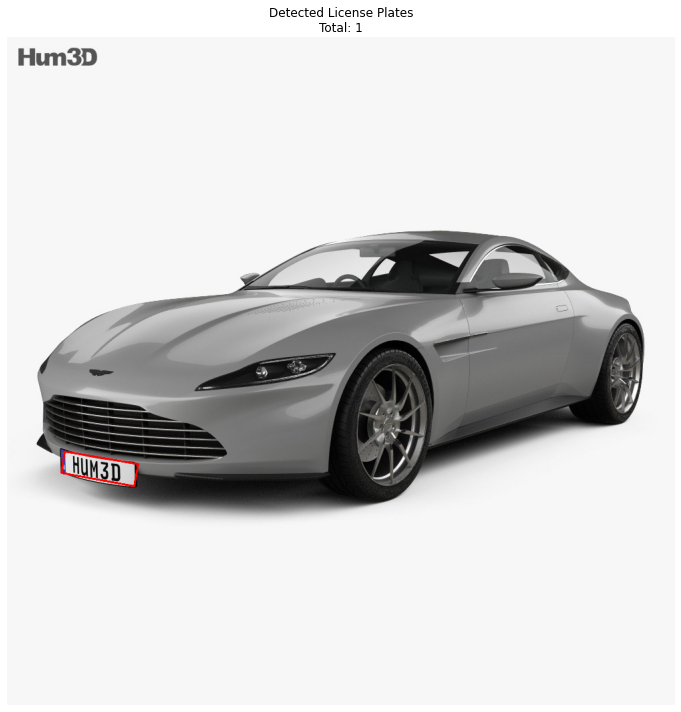

Number of valid contours found: 1
Contour 1: Area = 3507.0, Bounding Box = [[81, 652], [86, 620], [196, 639], [190, 672]], Aspect Ratio = 3.36


In [144]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
# img = cv2.imread('./images/db10.webp')  # Make sure to replace with the correct path to your image
img = cv2.imread('./images/db10_2.jpg')  # Replace with the correct path to your image
if img is None:
    raise ValueError("Image not found. Please check the file path.")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Apply Gaussian Blur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)

# Step 2: Perform Canny edge detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Step 3: Find contours from the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Filter contours based on aspect ratio and area
license_plate_contours = []
aspect_ratio_thresholds = (3.0, 5.0)  # Aspect ratio thresholds NOTA: European Licence plate 520mmx120mm => ratio = 4.7
area_threshold = 500  # Minimum area to consider

# Store the valid contours for plotting
valid_contours_info = []

for contour in contours:
    # Approximate the contour to a polygon
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

    # Get the minimum area rectangle for the contour
    min_area_rect = cv2.minAreaRect(approx)
    box_points = cv2.boxPoints(min_area_rect)
    box_points = np.int0(box_points)

    # Calculate width, height, and aspect ratio from the min area rectangle
    width, height = min_area_rect[1]
    if height == 0:  # Avoid division by zero
        continue
    aspect_ratio = max(width, height) / min(width, height)

    # Check if the aspect ratio matches our thresholds and if the area is significant
    if aspect_ratio_thresholds[0] <= aspect_ratio <= aspect_ratio_thresholds[1] and cv2.contourArea(contour) > area_threshold:
        license_plate_contours.append(box_points)
        valid_contours_info.append((cv2.contourArea(contour), box_points, aspect_ratio))

# Draw the detected license plate contours on the original image
output_image = img.copy()

# Plotting the results
plt.figure(figsize=(10, 10))

# Draw the contours on the output image
for box_points in license_plate_contours:
    cv2.drawContours(output_image, [box_points], -1, (0, 0, 255), 2)  # Draw in green

# Image with Detected License Plates
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected License Plates\nTotal: {len(license_plate_contours)}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Output results in specified format
print(f"Number of valid contours found: {len(license_plate_contours)}")
for i, (area, box_points, aspect_ratio) in enumerate(valid_contours_info, start=1):
    box_points_list = box_points.tolist()  # Convert numpy array to list for better display
    print(f"Contour {i}: Area = {area:.1f}, Bounding Box = {box_points_list}, Aspect Ratio = {aspect_ratio:.2f}")